The goal of this notebook is to study linear regression in dimension 1 with the formalism and theory studied in the article "On the Validation of Gibbs Algorithms: Training Datasets, Test Datasets and their Aggregation".

# Create three datasets with different noise levels

In [2]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import seaborn as sns



# parameters

N = 100 # datasets size
Lambda = 1
q = lambda x,y : 1 # probability density function of Q 

# create datasets

z1 = []

for i in range(N):
    x = np.random.normal(0,1)
    epsilon = np.random.normal(0,0.1)
    y = x + epsilon + 1
    z1.append((x,y))


z2 = []

for i in range(N):
    x = np.random.normal(0,1)
    epsilon = np.random.normal(0,5)
    y = x + epsilon +1
    z2.append((x,y))

z0 = z1 + z2



Define the functions needed to calculate the empirical risk.

In [3]:
# define loss function

def loss(y1,y2): 
    return (y1-y2)**2

# define prediction function

def approximation(a,b,t):
    return a*t+b

# define empirical risk

def empirical_risk(a,b,z):
    res = 0
    for i in range(len(z)):
        xi = z[i][0]
        yi = z[i][1]
        res += loss(approximation(a,b,xi),yi)
    res = res/N
    return res





The traditionnal method used in ML to find the parameters of the linear regression is to search for the parameters that minimize the empirical risk (ERM problem), we thus implement a gradient descent to solve this problem.

In [4]:
"""ERM solving using gradient descent"""

def gradient(a,b,z):
    Sa = 0
    for i in range(len(z)):
        xi = z[i][0]
        yi = z[i][1]
        Sa += xi * (a * xi + b - yi)
    Sa = Sa * (2/len(z))
    return Sa

def solve_ERM(a0,b0,epsilon,z,step):
    a1 = a0 - step * gradient(a0,b0,z)
    b1 = b0 - step * gradient(a0,b0,z)
    while (a1-a0)**2 +(b1-b0)**2 > epsilon**2:
        a0 = a1
        a1 = a0 - step * gradient(a0,b0,z)
        b0 = b1
        b1 = b0 - step * gradient(a0,b0,z)
    return a1,b1




The article studies another method, rather than determining a parameter vector, we seek the probability distribution of this vector. This probability distribution is the solution to the ERM-RER problem studied in the article.

In [5]:
"""ERM_RER solving"""

# define expected empirical risk

def expected_empirical_risk(f,z):
    def g(a,b):
        return f(a,b)*empirical_risk(a,b,z)
    return si.dblquad(g,-np.inf,np.inf,-np.inf,np.inf)




# define ERM_RER solving

def solve_ERM_RER(z,Lambda):
    def g(a,b):
        return np.exp(-empirical_risk(a,b,z)/Lambda)
    normalisation = si.dblquad(g,-np.inf,np.inf,-np.inf,np.inf)[0]
    def sol(a,b):
        return (np.exp(-empirical_risk(a,b,z)/Lambda))/normalisation
    return sol


f = solve_ERM_RER(z1,Lambda)


Let's visualize the probability distribution in question, for this we display the heatmap of the ERM-RER solution for several values of Lambda. We observe a concentration of the measure around the ERM solution when Lambda tends to 0.

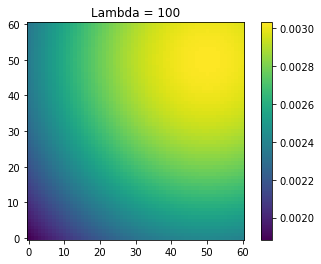

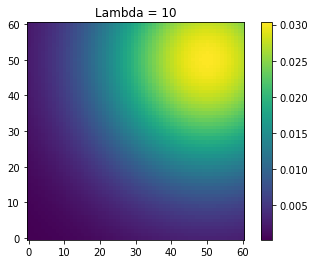

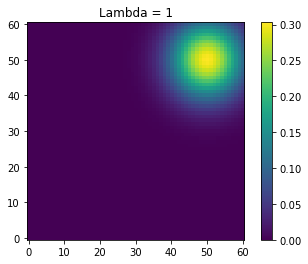

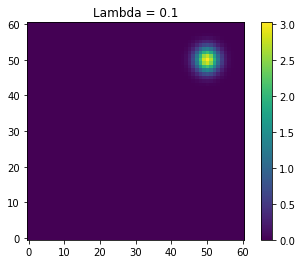

In [8]:
"""Visualization of the ERM_RER solution"""

import matplotlib.pyplot as plt

def visualization_ERM_RER(Lambda,z,n,pas):
    f = solve_ERM_RER(z,Lambda)
    M = np.zeros((2 * n * pas + 1 ,2 * n * pas + 1))
    for i in range(2 * n * pas + 1):
        for j in range(2 * n * pas + 1):
            M[i][j] = f(i / pas - n - 1,j / pas - n - 1)
    plt.imshow(M,origin="lower")
    plt.title("Lambda = " + str(Lambda))
    plt.colorbar()
    plt.show()



for param in [100,10,1,0.1]:
    visualization_ERM_RER(param,z1,3,10)


The following cell studies the question of the aggregation of datasets. Is it better to solve ERM-RER on two datasets separately and calculate the average measure of the two solutions or to solve ERM-RER on the merged dataset?

In [10]:
import time

# compute the solution for dataset z1

start = time.time()

f1 = solve_ERM_RER(z1,Lambda)

end = time.time()
elapsed = end - start

print(f'f1 execution time : {elapsed:.2}ms')

# compute the solution for dataset z2

start = time.time()

f2 = solve_ERM_RER(z2,Lambda)

end = time.time()
elapsed = end - start

print(f'f2 execution time : {elapsed:.2}ms')

# compute the solution for dataset z0

start = time.time()

f0 = solve_ERM_RER(z0,Lambda)

end = time.time()
elapsed = end - start

print(f'f0 execution time : {elapsed:.2}ms')

def sum(f1,f2):
    def g(a,b):
        return f1(a,b)+f2(a,b)
    return g

def scalar(f,alpha):
    def g(a,b):
        return alpha*f(a,b)
    return g

f3 = scalar(sum(f1,f2),0.5)
    

# compute the expected empirical risk for each solution

R1 = expected_empirical_risk(f1,z1)
R2 = expected_empirical_risk(f2,z2)
R0 = expected_empirical_risk(f0,z0)

print("R0 : " + str(R0) +" R1 : " + str(R1) +" R2 : " +str(R2))

F = [f0,f1,f2,f3]
z = [z0,z1,z2]
res = np.zeros((4,3))
for i in range(len(F)):
    for j in range(len(z)):
        res[i][j] = expected_empirical_risk(F[i],z[j])[0]
print(res)

f1 execution time : 7.3ms
f2 execution time : 0.94ms
f0 execution time : 1.5ms
R0 : (25.811795574068316, 2.4616361079596003e-08) R1 : (1.0110419748327322, 1.458808818468492e-08) R2 : (25.739640405755367, 1.973148014758466e-07)
[[25.81179557  0.50248152 25.30931405]
 [27.1415919   1.01104197 26.13054993]
 [26.71638131  0.9767409  25.73964041]
 [26.9289866   0.99389144 25.93509517]]


Now, let's evaluate the density of the ERM-RER solution at the ERM solution for Lambda between 0.01 and 0.5. We observe a divergence towards +infinity when lambda tends towards 0, this is not surprising because when Lambda tends towards 0, the problem is similar to the ERM problem so the ERM-RER solution measure is a dirac at the ERM solution.

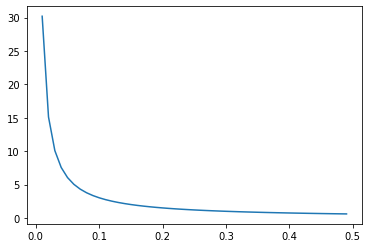

In [11]:
# visualization of the concentration measure
def visualization_concentration_measure(z,L):    # L is the list of lambda
    res = []
    a0, b0 = solve_ERM(1,1,10**-9,z,0.001)
    for Lambda in L:
        f0 = solve_ERM_RER(z,Lambda)
        res.append(f0(a0,b0))
    plt.plot(L,res)
    plt.show

L1 = [i/100 for i in range(1,50)]

visualization_concentration_measure(z1,L1)

